# Sentiment Classification using Kaggle's IMDB Movie Scores Dataset

The following compares model performance among some well-known supervised and unsupervised sentiment classification methods using [Kaggle's IMDB movie review dataset](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/notebooks). This dataset contains 50k movie reviews classified as either positive or negative reviews.

In [63]:
import pandas as pd
import json, warnings, nltk, multiprocessing
from scipy import stats
from collections import defaultdict
from tqdm import tqdm
import numpy as np
from time import time
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from clean_text import clean_text

# NLP modules
#nltk.download('wordnet') #  Necessary for first use
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant

# Performance metrics
from sklearn.metrics import confusion_matrix, roc_auc_score

pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)
warnings.simplefilter(action='ignore', category=FutureWarning)

### Function for performance metrics

In [2]:
def metrics(y_true, y_pred):
    '''
    Calculates binary classification performance metrics for a given model.
    :param y_true: array_like, truth values as int
    :param y_pred: array_like, predicted values as int
    :returns: dict, with keys for each metric: 
        accuracy - proportion of correct predictions out of total predictions
        sensitivity - (aka recall), of all true positives reviews how many did we correctly predict as positive
        specificity - (aka selectivity/TNR), of all true negatives how many did we correctly predict as negative
        precision - of all predicted positive cases how many were actually positive
        F-1 score - harmonic/weighted mean of precision and sensitivity scores
        ROC-AUC - area under receiver operating characteristic curve
        
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    metrics_dict = {}
    metrics_dict['accuracy'] = round((tp + tn) / len(y_true), 4)
    metrics_dict['sensitivity'] = round(tp / (fn + tp), 4) # aka recall
    metrics_dict['specificity'] = round(tn / (tp + fp), 4) # aka TNR
    metrics_dict['precision'] = round(tp / (tp + fp), 4)
    metrics_dict['f1'] = round(2 * (metrics_dict['precision'] * metrics_dict['sensitivity']) \
                        / (metrics_dict['precision'] + metrics_dict['sensitivity']), 4)
    metrics_dict['roc_auc'] = round(roc_auc_score(y_true, y_pred), 4)
    
    return metrics_dict

### Read data

In [3]:
df = pd.read_csv('../data/IMDB Dataset.csv')
print(df.shape)
df.head(2)

(50000, 2)


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive


To make things easier, I create a new integer feature that converts the string positive/negative review.

In [4]:
df['positive_sent'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# EDA

### Class distribution

negative    25000
positive    25000
Name: sentiment, dtype: int64


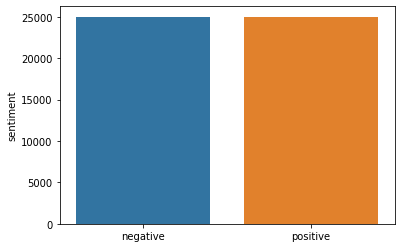

In [5]:
x = df.sentiment.value_counts()
sns.barplot(x.index, x)
print(x)

Classes are balanced in the data, meaning we can rely on all of the performance metrics above. If, for example, the data were highly imbalanced (e.g. nearly all positive or negative reviews), accuracy measures would provide little meaningful information. The reason being, it's mechanically easier to correctly predict the dominant class given its numerical abundance.

### Distribution of words by class

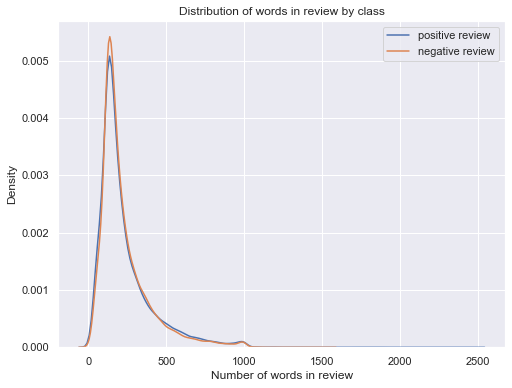

In [6]:
sns.set(rc={'figure.figsize':(8,6)})
positive = df[df.sentiment=='positive']['review'].str.split().map(lambda x: len(x)) # pd.Series with total word count per row
negative = df[df.sentiment=='negative']['review'].str.split().map(lambda x: len(x))
sns.kdeplot(positive, label='positive review') # kernel density plot
sns.kdeplot(negative, label='negative review')
plt.legend()
plt.title('Distribution of words in review by class')
plt.xlabel('Number of words in review')
plt.show()

Are there apparent differences in the number of words used in positive versus negative reviews? Not a lot, though the mass of negative reviews is slightly more concentrated (i.e. higher) on the left, indicating negative reviews are somewhat shorter. We see this below.

In [7]:
print(round(positive.mean(), 2), 'positive review')
print(round(negative.mean(), 2), 'negative review')
print(round(positive.mean() - negative.mean(), 2), 'word difference')

232.85 positive review
229.46 negative review
3.38 word difference


### Distribution of characters in review by class

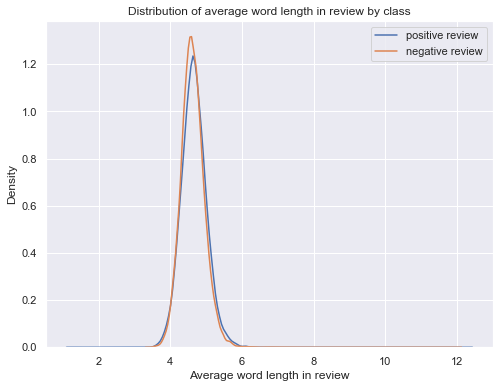

In [8]:
positive = df[df['sentiment']=='positive']['review'].str.split().apply(lambda x : [len(i) for i in x]) # pd.Series with list of individual word lengths per row
negative = df[df['sentiment']=='negative']['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.kdeplot(positive.map(lambda x: np.mean(x)), label='positive review')
sns.kdeplot(negative.map(lambda x: np.mean(x)), label='negative review')
plt.legend()
plt.title('Distribution of average word length in review by class')
plt.xlabel('Average word length in review')
plt.show()

In [9]:
positive = positive.map(lambda x: np.mean(x)) # pd.Series where each row is average word length per row
negative = negative.map(lambda x: np.mean(x))
print(round(positive.mean(), 2), 'positive review')
print(round(negative.mean(), 2), 'negative review')
print(round(positive.mean() - negative.mean(), 2), 'word difference')

4.66 positive review
4.62 negative review
0.03 word difference


We see that negative reviews tend to use slightly shorter words, on average, than positive reviews.

# Data cleaning

I clean the reviewer text data with `clean_text`, a class I created that among other things removes non-characters (e.g. URLs, emojis), removes contractions, lowercases words, removes punctuation, converts numbers to characters, and removes stopwords. Optionally, it can lemmatize words, correct spelling, enforce a minimum character length of words, or enforce a minimum word frequency.

In [10]:
start = time()
clean = clean_text().run(df['review'], lemmatize=False)
print('Total cleaning run time:', round(time() - start, 0), 'seconds')

Total cleaning run time: 64.0 seconds


In [11]:
print('Review, original: \n', df['review'].head(1).values[0])
print('\nReview, cleaned: \n', clean.head(1).values[0])

Review, original: 
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the sh

### Word frequency

Having removed English stopwords from the text (e.g. me, they, be), let's explore word frequency in order to remove words below a certain threshold frequency. As shown below, there are 144,917 unique words in this dataset. Of these, 73,308 appear only once. Most of these are misspellings or simply irregular words and hence best removed, which I do below.

In [12]:
temp = [i.split() for i in clean] 
freq = defaultdict(int)  # Get freq of each word across all documents
for indiv_doc in temp:
    for token in indiv_doc:
        freq[token] += 1
        
word_freq = pd.DataFrame.from_dict(freq, orient='index')\
    .reset_index().rename(columns={'index': 'word', 0: 'freq'})

In [13]:
print(word_freq['freq'].describe())

count    144917.000000
mean         41.037063
std         536.498508
min           1.000000
25%           1.000000
50%           1.000000
75%           6.000000
max       85848.000000
Name: freq, dtype: float64


In [14]:
print(f"Number of words that appear only once in corpus: {len(word_freq[word_freq['freq']==1])}")

Number of words that appear only once in corpus: 73308


In [15]:
print('Some examples of rare words:')
word_freq[word_freq['freq']==1]['word'].head(10)

Some examples of rare words:


140      oldtimebbc
155          polari
197      halliwells
315          petter
376        discerns
431       dressedup
522      guesthosts
525    handselected
681       finsished
692         schemed
Name: word, dtype: object

In [16]:
# Keep words if used >1 time across corpus
clean = clean_text().remove_infreq_words(clean, min_word_freq=2)

### Lemmatization

Finally, I *lemmatize* words, e.g. convert plural nouns to singular, infinitive verbs to present tense. I use NLTK's part-of-speech tagger that classifies words into their part of speech (e.g. adjective, adverb) and then lematizes the word. I prefer lemmatization to [stemming](https://medium.com/@tusharsri/nlp-a-quick-guide-to-stemming-60f1ca5db49e) as the latter typically yields less accurate results due to declination or conjugation of words for their particular part-of-speech use.<sup>\([1](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)\)</sup>

In [17]:
start = time()
df['review_clean'] = clean_text().lematizer(clean)
print('Total cleaning run time:', round(time() - start, 0), 'seconds')

Total cleaning run time: 796.0 seconds


### Train-test split

To evaluate model performance on unseen data, we split the data into train and test sets using scikit-learn's `train_test_split` method. Both the original, unprocessed review is included alongside the cleaned review. 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df[['review', 'review_clean']], df['positive_sent'], test_size=0.2, 
                                                    random_state=123)

In [19]:
print(X_train.shape)
print(X_test.shape)

(40000, 2)
(10000, 2)


# Unsupervised sentiment classification

Unsupervised learning is a family of machine learning algorithms that use data with no existing truth labels. Although the IMDB dataset contains truth labels, for later comparison with better-known supervised NLP algorithms (e.g. Naive Bayes, LSTM) I generate predictions using two unsupervised sentiment analysis algorithms: VADER and TextBlob. In particular, because these two algorithms are lexicon- rather than learning-based, I calculate predictions directly for the test subset.

## Valence Aware Dictionary and sEntiment Reasoner (VADER)

VADER is a popular a rule/lexicon-based sentiment analyzer. Lexicon approaches use a pre-defined dictionary of words and phrases, which are rated for polarity and intensity. VADER's lexicon contains about 7,500 sentiment features, which are scored each scored between extremely negative [-4] to extremely positive [+4]) by a panel human experts. Words not included in the lexicon are awarded a neutral sentiment of 0. VADER also makes use of the grammatical structure of documents (e.g. punctuation, capitalization, contrasting conjunctions). To calculate the compound sentiment score of a given document, VADER calculates the sum of the sentiment of all features in that document, and normalizes to [-1, 1]. <sup>\([2](https://medium.com/ro-data-team-blog/nlp-how-does-nltk-vader-calculate-sentiment-6c32d0f5046b)\)</sup> Further information and source code can be found at VADER's [GitHub](https://github.com/cjhutto/vaderSentiment).

In [20]:
sid = SentimentIntensityAnalyzer() # instantiate VADER

NLTK's VADER accepts documents as a string; thus, we must iterate individually over each document in the corpus. For each document, `SentimentIntensityAnalyzer`'s `polarity_scores` returns a dictionary of length four. I focus on the last key, `compound`, which offers the normalized polarity (sentiment) score. Because VADER is built to calculate sentiment from the grammatical structure of documents, I calculate sentiment scores using the original, raw reviews.

In [21]:
print(sid.polarity_scores(X_test['review'].values[0]))
print("Actual rating:", y_test.iloc[0], '(negative)')

{'neg': 0.138, 'neu': 0.792, 'pos': 0.07, 'compound': -0.9187}
Actual rating: 0 (negative)


In [22]:
start = time()
lst = []
for i in range(len(X_test)):
    pred = sid.polarity_scores(X_test.iloc[i].values[0])['compound']
    lst.append(pred)
vader = pd.Series(lst, index=y_test.index)
print('Total model run time:', round(time() - start, 0), 'seconds')

Total model run time: 20.0 seconds


Finally, because this is a classification exercise (i.e. the truth values are categories, not continuous sentiment values), we convert positive sentiment scores to 1 and negative scores to 0.

In [23]:
vader = np.where(vader > 0, 1, 0)

In [24]:
metrics_dict = {}
metrics_dict['vader'] = metrics(y_test, vader)

In [25]:
print('VADER performance:')
for key, value in metrics_dict['vader'].items():
    print(key, ':', value)

VADER performance:
accuracy : 0.6923
sensitivity : 0.8552
specificity : 0.3957
precision : 0.6463
f1 : 0.7362
roc_auc : 0.6916


Out-of-the-box VADER performs well in classifying sentiment scores with these data. It correctly classifiees the sentiment in 69.23% of reviews in the test set. VADER's performance, however, differs considerably between positive and negative reviews. On the one hand, it correctly classifies 85.52% of all positive reviews; yet on the other, it only correctly classifies 39.57% of negative reviews. If one were particularly interested in positive or negative reviews it would be advisable to adjust the classifer threshold using a precision-recall curve and/or F-score. For parsimony, and because the goal of this exercise is accuracy performance, I forego this additional step.

## TextBlob

TextBlob is an NLP library offering a host of tools, including parts-of-speech tagging, sentiment analysis, and noun phrase extraction, among others. Further information and source code can be found at TextBlob's [GitHub](https://github.com/sloria/textblob). 

Like VADER, TextBlob accepts individual documents as strings, meaning we must iterate over all documents to calculate a sentiment vector. `TextBlob().sentiment` returns a namedtuple, where the first element is the polarity (sentiment) score with a range [-1.0, 1.0] and the second is the subjectivity score with range [0.0, 1.0]. Since TextBlob is built to handle raw text, we use the original, raw reviews to generate predictions.


In [26]:
print(TextBlob(X_test.iloc[0].values[0]).sentiment)
print("Actual rating:", y_test.iloc[0], '(negative)')

Sentiment(polarity=-0.07177083333333334, subjectivity=0.6366666666666666)
Actual rating: 0 (negative)


In [27]:
start = time()
lst = []
for i in range(len(X_test)):
    pred = TextBlob(X_test.iloc[i].values[0]).sentiment.polarity
    lst.append(pred)
textblob = pd.Series(lst, index=y_test.index).apply(lambda x: 1 if x > 0 else 0)
print('Total model run time:', round(time() - start, 0), 'seconds')

Total model run time: 12.0 seconds


In [28]:
metrics_dict['textblob'] = metrics(y_test, textblob)

In [29]:
print('TextBlob performance:')
for key, value in metrics_dict['textblob'].items():
    print(key, ':', value)

TextBlob performance:
accuracy : 0.6809
sensitivity : 0.9428
specificity : 0.2717
precision : 0.6198
f1 : 0.7479
roc_auc : 0.6798


As with VADER, TextBlob performs well with no tuning. TextBlob's accuracy is even marginally better than VADER. Even more than VADER though, we see large performance differences between classes; while the model correctly classifies 94% of positive reviews, it only correctly classifies 27% of negative reviews.

# Supervised sentiment classification

## Naive Bayes classifier

Naive Bayes is a family of simple, supervised learning algorithms that use Bayes' theorem combined with a strong "naive" assumption of conditional independence between features given the value of the outcome variable. Although this assumption is frequently violated in many real-world applications, naive Bayes algorithms often work well as classifiers (e.g. especially in document classification and spam filtering), though they tend to be poor estimators. An explanation for this paradox can be found [here](https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf); essentially, the answer lies in the distribution of dependence within a class often cancelling each other out. Compared to more sophisticiated classifiers, naive Bayes classifiers are extremely fast and scalable. \[[3](https://scikit-learn.org/stable/modules/naive_bayes.html)\]

This naive Bayes classifier model is based on a "bag of words" (BOW) approach, which converts text (words or word combinations) into numerical representation for analysis. The BOW approach, however, only focuses on the number of times a given word appears in a document, not the order of words (as compared to more sophisticiated context-dependent algorithms like BERT). Specifically, I use sklearn's `CountVectorizer`, which counts the number of tokens present  per document among all tokens in the corpus. By default, `CountVectorizer` removes punctuation and changes words lowercase; I also remove non-alphanumeric characters with NLTK's regex tokenizer and English stopwords. Code and inspiration for this method were drawn in part from [this article](https://towardsdatascience.com/sentiment-analysis-introduction-to-naive-bayes-algorithm-96831d77ac91).

Because there is per-se no default algorithm for sklearn's Naive Bayes API, I began by comparing model performance across algorithms. I also experiment with two other hyperparameter n-gram, and vectorizer.

### Hyperparameter: Naive Bayes algorithm

In [30]:
cv = CountVectorizer(stop_words='english', ngram_range=(1,1), 
            tokenizer=RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize) # monogram
train_counts = cv.fit_transform(X_train['review_clean']) # scipy.sparse.csr.csr_matrix
test_counts = cv.transform(X_test['review_clean']) # use `transform` instead of `fit_transform` to ensure same feature dims

In [31]:
start = time()
BNB = BernoulliNB()
BNB.fit(train_counts, y_train)
bern_predictions = BNB.predict(test_counts) # returns np.ndarray
print('Total model run time:', round(time() - start, 0), 'seconds')

start = time()
MNB = MultinomialNB()
MNB.fit(train_counts, y_train)
mult_predictions = MNB.predict(test_counts) # returns np.ndarray
print('Total model run time:', round(time() - start, 0), 'seconds')

Total model run time: 0.0 seconds
Total model run time: 0.0 seconds


In [32]:
print("BernoulliNB performance:")
for key, value in metrics(y_test, bern_predictions).items():
    print(key, ':', value)
    
print("\nMultinomialNB performance:")
for key, value in metrics(y_test, mult_predictions).items():
    print(key, ':', value)

BernoulliNB performance:
accuracy : 0.8453
sensitivity : 0.8106
specificity : 0.9393
precision : 0.8723
f1 : 0.8403
roc_auc : 0.8454

MultinomialNB performance:
accuracy : 0.8543
sensitivity : 0.8367
specificity : 0.8975
precision : 0.8683
f1 : 0.8522
roc_auc : 0.8544


True to form, the naive Bayes model trains very quickly and exhibits decent classification performance! Performance between the Bernoulli and Multinomial classifiers are very similar; I'll call it for Multinomial. 

### Hyperparmeter: N-gram

In [33]:
cv = CountVectorizer(stop_words='english', ngram_range=(2,2), 
            tokenizer=RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize) 
train_counts = cv.fit_transform(X_train['review_clean']) 
test_counts = cv.transform(X_test['review_clean'])
MNB = MultinomialNB()
MNB.fit(train_counts, y_train)
mult_predictions_ngram = MNB.predict(test_counts) 
for key, value in metrics(y_test, mult_predictions).items():
    print(key, ':', value)

accuracy : 0.8543
sensitivity : 0.8367
specificity : 0.8975
precision : 0.8683
f1 : 0.8522
roc_auc : 0.8544


Increasing from monograms to bigrams raised performance accuracy nearly 2 percentage points! Supplementary analyses showed performance decreased with trigrams, so we'll stick with bigrams.

### Hyperparameter: Vectorizer (TF-IDF)

In [34]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(2,2), 
            tokenizer=RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize) 
train_counts = tfidf.fit_transform(X_train['review_clean']) 
test_counts = tfidf.transform(X_test['review_clean'])
MNB = MultinomialNB()
MNB.fit(train_counts, y_train)
mult_predictions_tfidf = MNB.predict(test_counts) 
for key, value in metrics(y_test, mult_predictions).items():
    print(key, ':', value)

accuracy : 0.8543
sensitivity : 0.8367
specificity : 0.8975
precision : 0.8683
f1 : 0.8522
roc_auc : 0.8544


Term frequency-inverse document frequency (TF-IDF) is a statistic reflecting the importance of a word in a document, defined by the number of times a word appears in a document compared to the number of documents containing the word. For a helpful introduction see [this article](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089). Using sklearn's `TfidfVectorizer`, as compared to the `CountVectorizer`, slightly decreases model performance. So we'll stick with the results from the N-gram-optimzed model.

In [35]:
metrics_dict['naive_bayes'] = metrics(y_test, mult_predictions_ngram)

## Word Embeddings, GloVe, and LSTM

Word embeddings are dense, distributed real-value vector representations of words, which are often tens or hundreds of dimensions. Each dimension can be thought of as an abstract feature that captures semantic, contextual, and syntactic meanings of words based on their learned usage.<sup>\[[4](https://medium.com/@b.terryjack/nlp-everything-about-word-embeddings-9ea21f51ccfe)\]</sup> These dense vector representations contrast with a sparse one-hot vector representations of words (e.g. `CountVectorizer`), which are not only a computationally inefficient way to represent data, but unable to capture the similarity of words as they represent words as independent.

The two most popular word embeddings algorithms are [Word2Vec](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) and [GloVe](https://nlp.stanford.edu/projects/glove/), which are both unsupervised learning approaches. Originally proposed by Thomas Mikolov and colleagues at Google in 2013,<sup>\[[5](https://arxiv.org/pdf/1310.4546.pdf)\]</sup> Word2Vec is built upon a shallow, two-layer feed-forward neural network that relies on one of two architectures: *continuous bag-of-words (CBOW)* or *continuous skip-gram*. Whereas CBOW approach models the target (middle) word given the surrounding context words, skip-gram models the context words given the current word in a sentence. Both approaches require specification of the *context window*, or the number of adjacent words (typically 5-10), to infer the similarity of words. Proposed in 2014 by [Stanford researchers](https://nlp.stanford.edu/pubs/glove.pdf), GloVe offers a different word embedding approach using matrix factorization. Unlike Word2Vec, which infers word meaning based only on local contextual information of words, GloVe relies on both local and *global* word context by aggregating word-word co-occurrence for a corpus (see [this article](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010) for a more in-depth explanation). The authors of GloVe argue their approach allows this method to better differentiate the specific meaning of words among related words<sup>\[[6](https://nlp.stanford.edu/projects/glove//)\]</sup> (though not to the degree of understanding contextual and multiple word meanings as with [contextual word embeddings like ELMo](https://towardsdatascience.com/elmo-contextual-language-embedding-335de2268604) or [transformer-based architectures like BERT](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)). In practice, however, both algorithms often perform similarly for many tasks, while the particular dataset and number of embedding dimensions tends to have a larger impact on performance.<sup>\[[7](https://machinelearninginterview.com/topics/natural-language-processing/what-is-the-difference-between-word2vec-and-glove/)\]</sup> 

One of the most promising ideas in NLP is *transfer learning*. Though this can refer to a variety of techniques,<sup>\[[8](https://ruder.io/state-of-transfer-learning-in-nlp/)\]</sup> this typically refers to training a supervised model in one task in one domain and applying that trained model to a related task or domain.<sup>\[[9](https://ruder.io/transfer-learning/)\]</sup> This approach not only vastly speeds up training time, but also reduces problems associated with modeling an inadequately-sized sample or a sample with insufficient variation. Rather than train an embedding model using the comparably-small IMDB Movie Review dataset, I use pretrained GloVe embeddings available from the [Stanford GloVe Project's website](https://nlp.stanford.edu/projects/glove/). Several versions are available; I use the 2014 Wikipedia edition containing 6 billion tokens and 400k unique words. There are 50d, 100d, 200d, and 300d vectors available for this dataset. I use the 300d variant. 

Word vectors cannot be directly used to classify sentiment (or any other modeled outcome). Generally, researchers use these vector representations as an input to a stand-alone supervised learning model. In particular, because text data contain temporal dependencies between words in the same document, [recurrent neural network (RNN)](https://towardsdatascience.com/recurrent-neural-networks-d4642c9bc7ce) are best suited to this task. Although it is possible to capture time dependencies with tree-based and feedforward neural networks with properly-engineered features, RNNs share information from upstream inputs via a *hidden state*, providing that information to downstream inputs. I use a variant of RNN called [long short-term memory [LSTM]](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), which are specifically designed to learn long-term dependencies. The core idea of LSTMs is the *cell state*, which acts as the hidden state allowing and allows information to potentially flow through unchanged. Information is added or removed from the cell state by a series of *gates* (e.g. an "input gate", "output gate", and "forget gate"). For brevity, I only use a LSTM model, though it's best to compare performance with another RNN, the [gated recurrent unit [GRU]](https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b).

### Preparation

Compared to earlier NLP methods, feeding text data to a neural network involves a few more preprocessing steps.

#### Embedding dictionary 

We begin by creating an embedding dictionary, which contains each word in the GloVe file along with its 300d vector representations.

In [80]:
word_vector_dim = 300
embedding_dict = {}
path = f'../data/glove.6B/glove.6B.{word_vector_dim}d.txt'
with open(path, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors
f.close()

print(f"Embedding dictionary contains {len(embedding_dict.keys())} unique entries")

Embedding dictionary contains 400001 unique entries


#### Tokenize words via hashmap

In [81]:
def tokenize(lst):
    '''
    Create a word-to-index dictionary (hashmap) that maps each word in corpus/dataframe to a key, with
        a numeric index (value) for each key. These values are represented in sequences.
    :param lst: list of lists
    :returns:
        0) word-to-index dictionary, where length if number of unique words in corpus
        1) list of lists, where each sublist is a particular text row in cleaned data. 
        Elements in this sublist correspond to a value in the word-to-index dictionary, where
        key corresponds to word.
    '''
    tokenizer_obj = Tokenizer() # keeps most frequent n_words-1
    tokenizer_obj.fit_on_texts(lst)
    sequences = tokenizer_obj.texts_to_sequences(lst)
    word_index = tokenizer_obj.word_index
    return word_index, sequences

In [82]:
word_index, X_train_seq = tokenize(X_train['review_clean'])
_, X_test_seq = tokenize(X_test['review_clean'])

In [83]:
# Example of first 5 words in row 1 of X_train
X_train_seq[0][:5]

[464, 32, 113, 582, 148]

#### Word padding

When training a deep learning model via minibatch gradient descent, tokenized sentence sequences must have the same number of timestamps (i.e. words) per minibatch. We use Tensorflow Keras' `pad_sequences` method for this, truncating and padding excess words beyond a threshold with a value of zero.

In [84]:
def pad_words(sequence, maxlen=200):
    '''
    Transforms a list of length num_samples of sequences (i.e. list of integers) into 2D numpy array of shape
        (num_samples, maxlen). Individual words in a given sequence/list after maxlen are truncated. Short
        sequences are padded at the end with zeros so that all sequences have the same length.
    :param maxlen: int, maximum length of all sequences
    :return: Numpy 2D array of shape (num_samples, maxlen)
    '''
    return pad_sequences(sequence, maxlen=maxlen, truncating='post', padding='post')

There is considerable variation in the number of words per review even among the cleaned reviews (see below). To allow the model to train on a sufficient number of words per review, while also shortening reviews of extreme length I cap the number of words at 200, which corresponds to the 86.55th percentile. An alternative strategy would be to pad using the length of the longest review in the training set (1,376), though this would considerably increase training time.

In [66]:
print(round(X_train['review_clean'].str.split()\
            .map(lambda x: len(x)).describe(), 2))

print("\n", stats.percentileofscore(X_train['review_clean'].str.split()\
            .map(lambda x: len(x)), 200), 'percentile')

count    40000.00
mean       117.31
std         88.62
min          3.00
25%         63.00
50%         87.00
75%        143.00
max       1376.00
Name: review_clean, dtype: float64

 86.55125 percentile


In [85]:
max_words_sequence = 200
X_train_pad = pad_words(X_train_seq, max_words_sequence)
X_test_pad = pad_words(X_test_seq, max_words_sequence)

#### Embedding matrix

I create an embedding matrix, which will be used in the input layer of a deep learning model. This is a 43,308 x 300 matrix, where whe number of rows corresponds to the number of unique words in `X_train` and the number of columns corresponds to the number of embedding dimensions. Intiutively, I loop through all unique words in the training set, selecting only these word vectors. An alternative, less efficient approach would be to use all words and their embeddings contained in the GloVe file; however, only about 1/10 are present in the training set, so this would increase training time.

In [86]:
num_words = len(word_index) + 1 # number of unique words in corpus +1 for reserved 0 index
embedding_matrix = np.zeros((num_words, word_vector_dim))

for word, i in tqdm(word_index.items()):
    if i > num_words:
        continue
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

100%|██████████| 43307/43307 [00:00<00:00, 298672.93it/s]


#### Tensorflow Keras Sequential model

[Keras](https://keras.io/) is a high-level deep learning API built on top of Google's [Tensorflow](https://www.tensorflow.org/). Starting with Tensorflow 2, Keras is integrated into Tensorflow. I use a `Sequential` class model, which stacks layers linearly and accepts only one input tensor and outputs only one tensor. 

I use an `Embedding` layer as the first hidden layer in this model, initializing the weights for this layer with the embedding matrix. I set this layer as untrainable, meaning the weights will not be updated via backpropagation. On the one hand, this means that the model will not update the word vectors to potentially reflect additional information learned about the vocabulary in the training set. Yet on the other, this restriction reduces training time. This layer accepts as an input a 2D tensor with the shape (minibatch_size, max_words_per_review). It outputs a 3D tensor in with a shape (minibatch_size, max_words_per_review, word_vector_dimensions). 



In [92]:
clear_session()

model = Sequential() # instantiates Sequential class model

embedding = Embedding(input_dim=len(word_index)+1, 
                      output_dim=word_vector_dim,
                      input_length=max_words_sequence, 
                      embeddings_initializer=Constant(embedding_matrix),
                      trainable=False)

model.add(embedding)

model.add(SpatialDropout1D(0.2))

model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam()

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

In [88]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          12992400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 13,212,177
Trainable params: 219,777
Non-trainable params: 12,992,400
_________________________________________________________________
None


#### Train model

Explanation..

In [89]:
start = time()

hist = model.fit(X_train_pad, 
                 y_train, 
                 batch_size=64,
                 epochs=30, 
                 validation_split=0.25, 
                 verbose=2,
                 callbacks=[EarlyStopping(monitor='val_loss', mode='min',
                 patience=3, restore_best_weights=True)])

print('Total training time:', round((time() - start) / 60, 2), 'minutes')

Epoch 1/20
469/469 - 137s - loss: 0.6914 - accuracy: 0.5205 - val_loss: 0.6895 - val_accuracy: 0.5134
Epoch 2/20
469/469 - 134s - loss: 0.6718 - accuracy: 0.5677 - val_loss: 0.6894 - val_accuracy: 0.5214
Epoch 3/20
469/469 - 135s - loss: 0.6837 - accuracy: 0.5288 - val_loss: 0.6858 - val_accuracy: 0.5208
Epoch 4/20
469/469 - 134s - loss: 0.6877 - accuracy: 0.5218 - val_loss: 0.6913 - val_accuracy: 0.5115
Epoch 5/20
469/469 - 138s - loss: 0.6783 - accuracy: 0.5465 - val_loss: 0.5950 - val_accuracy: 0.6791
Epoch 6/20
469/469 - 130s - loss: 0.4924 - accuracy: 0.7781 - val_loss: 0.4220 - val_accuracy: 0.8145
Epoch 7/20
469/469 - 130s - loss: 0.3945 - accuracy: 0.8299 - val_loss: 0.3591 - val_accuracy: 0.8449
Epoch 8/20
469/469 - 133s - loss: 0.3620 - accuracy: 0.8445 - val_loss: 0.3376 - val_accuracy: 0.8558
Epoch 9/20
469/469 - 133s - loss: 0.3431 - accuracy: 0.8531 - val_loss: 0.3270 - val_accuracy: 0.8593
Epoch 10/20
469/469 - 132s - loss: 0.3269 - accuracy: 0.8611 - val_loss: 0.3487 - 